# Lab 2
# Tracking position with visual markers

Position tracking can be achieved even with a single camera when an object is recorded whose size is known a priori. When possible, it is convenient to use visual markers. Visual markers facilitate the feature detection as they have sharp edges and high-contrast colors. An example of visual markers are the ArUCo (Augmented Reality University of Cordoba) markers (see figure below), which were developed for the pose estimation in augmented reality applications. The main benefit of these markers is that a single marker provides enough correspondences (its four corners) to obtain the marker pose with respect to the camera frame. Also, the inner binary codification makes them specially robust, allowing the possibility of applying error detection and correction techniques.

<img src="arucoMarkers.jpg" width="500"/>

The developer who propose ArUCo markers also shared a library using OpenCV to estimate their pose. After that, such library has been integrated into OpenCV. Therefore, we will use the python OpenCV library to get the pose of ArUCo markers and thus track the pose of the objects where the markers are placed.

## OpenCV basics

As above mentioned, we will use the Python OpenCV library. Here, some basic OpenCV functions are detailed. The OpenCV library is imported by the following import command:

`import cv2`

Here is an example of how open a video for processing its frames:

`video = cv2.VideoCapture(<filename>)`

If the argument is 0, the function will acquire the video using the default computer camera. To know the number of frames in the video, you can read one of the property of the video object:

`nframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))`

To get a frame from the video, you can use the read method:

`ret, frame = video.read()`

Once the processing is complete, you can release the video object as:

`video.release()`

You may want to save a modified version of your video. To do it, you can use the VideoWriter class. An object of this class should be instantiated as:

`writer = cv2.VideoWriter(<filename>,                       # please pay attention that only .avi format is supported
                           cv2.VideoWriter_fourcc(*'MJPG'),
                           <fps>,                           # frames per second
                           <frame size>)                    # frame size as a couple`

To write a frame, the following funciton is used:

`writer.write(frame)`

Finally you should release the VideoWriter object:

`writer.release()`

## Calibrate the camera

The real position of an object in the image is related to the position of its image in the picture, by some parameters of the camera, such as the number of pixels, the sensor size and the focal length. Moreover, the lens often distort the image. For these reasons, the first step to be done is to calibrate our camera. The camera calibration allows us to estimate the transformation to apply to the image to get real world dimensions.


Camera calibration is usually done using a chessboard image. OpenCV provides one, at the following link: [https://github.com/opencv/opencv/blob/master/doc/pattern.png](https://github.com/opencv/opencv/blob/master/doc/pattern.png) (I already downloaded and printed for you)

A set of images of the chessboard, at different distances and orientations should be acquired. You can store them in a specific folder. About 20 images are enough to get the calibration. Alternatively, you can take a video moving the chessboard and using the video frames to calibrate. Here is a sample code to calibrate the camera using the frames sampled from a video. After the calibration, the code stores the calibration parameters in a .yaml file for using them during measurements.

Take a video with the chessboard at different positions and orientations. Then, copy the video in a CameraCalibration folder inside the folder of this notebook. Finally, complete the code below with the name of the video and perform the calibration running the code.

In [11]:
import cv2 # Import the OpenCV library to enable computer vision
import numpy as np # Import the NumPy scientific computing library
import glob # Used to get retrieve files that have a specified pattern
  
# Chessboard dimensions
number_of_squares_X = 10 # Number of chessboard squares along the x-axis
number_of_squares_Y = 7  # Number of chessboard squares along the y-axis
nX = number_of_squares_X - 1 # Number of interior corners along x-axis
nY = number_of_squares_Y - 1 # Number of interior corners along y-axis
square_size = 0.024 # Size, in meters, of a square side 
  
# Set termination criteria. We stop either when an accuracy is reached or when
# we have finished a certain number of iterations.
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) 
 
# Define real world coordinates for points in the 3D coordinate frame
# Object points are (0,0,0), (1,0,0), (2,0,0) ...., (5,8,0)
object_points_3D = np.zeros((nX * nY, 3), np.float32)  
  
# These are the x and y coordinates                                              
object_points_3D[:,:2] = np.mgrid[0:nY, 0:nX].T.reshape(-1, 2) 
 
object_points_3D = object_points_3D * square_size
 
# Store vectors of 3D points for all chessboard images (world coordinate frame)
object_points = []
  
# Store vectors of 2D points for all chessboard images (camera coordinate frame)
image_points = []
      
cap = cv2.VideoCapture("CameraCalibration\MVI_7085.MOV")
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Sample one over 20 frames of the video
for n in range(0,length,5):

    # Load the image
    print(f"Reading frame %d of %d" % (n//20+1,length//20+1))  
    # Capture frame-by-frame
    # This method returns True/False as well
    # as the video frame.
    ret, frame = cap.read()

    # Convert the image to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  

    # Find the corners on the chessboard
    success, corners = cv2.findChessboardCorners(gray, (nY, nX), None)

    # If the corners are found by the algorithm, draw them
    if success == True:

      # Append object points
      object_points.append(object_points_3D)

      # Find more exact corner pixels       
      corners_2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)       

      # Append image points
      image_points.append(corners_2)

      # Draw the corners
      cv2.drawChessboardCorners(frame, (nY, nX), corners_2, success)


      # Perform camera calibration to return the camera matrix, distortion coefficients, rotation and translation vectors etc 
      ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, 
                                                        image_points, 
                                                        gray.shape[::-1], 
                                                        None, 
                                                        None)


# Save parameters to a file
print("Saving camera calibration parameters...")
cv_file = cv2.FileStorage('calibration_chessboard.yaml', cv2.FILE_STORAGE_WRITE)
cv_file.write('K', mtx)
cv_file.write('D', dist)
cv_file.release()
print("...done.")

# Load the parameters from the saved file
cv_file = cv2.FileStorage('calibration_chessboard.yaml', cv2.FILE_STORAGE_READ) 
mtx = cv_file.getNode('K').mat()
dst = cv_file.getNode('D').mat()
cv_file.release()

# Display key parameter outputs of the camera calibration process
print("Camera matrix:") 
print(mtx) 

print("\n Distortion coefficient:") 
print(dist) 

# Close all windows
cv2.destroyAllWindows() 

Reading frame 1 of 29
Reading frame 1 of 29
Reading frame 1 of 29
Reading frame 1 of 29
Reading frame 2 of 29
Reading frame 2 of 29
Reading frame 2 of 29
Reading frame 2 of 29
Reading frame 3 of 29
Reading frame 3 of 29
Reading frame 3 of 29
Reading frame 3 of 29
Reading frame 4 of 29
Reading frame 4 of 29
Reading frame 4 of 29
Reading frame 4 of 29
Reading frame 5 of 29
Reading frame 5 of 29
Reading frame 5 of 29
Reading frame 5 of 29
Reading frame 6 of 29
Reading frame 6 of 29
Reading frame 6 of 29
Reading frame 6 of 29
Reading frame 7 of 29
Reading frame 7 of 29
Reading frame 7 of 29
Reading frame 7 of 29
Reading frame 8 of 29
Reading frame 8 of 29
Reading frame 8 of 29
Reading frame 8 of 29
Reading frame 9 of 29
Reading frame 9 of 29
Reading frame 9 of 29
Reading frame 9 of 29
Reading frame 10 of 29
Reading frame 10 of 29
Reading frame 10 of 29
Reading frame 10 of 29
Reading frame 11 of 29
Reading frame 11 of 29
Reading frame 11 of 29
Reading frame 11 of 29
Reading frame 12 of 29
R

## ArUCo marker detection

ArUCo markers are grouped into dictionaries depending on the size and properties of the markers. We will use the dictionary called DICT_4X4_1000, where markers are of size 4cm x 4cm. To detect an ArUCo marker the following steps are needed:

1. recall the camera calibration parameters:

        # Load the camera parameters from the saved file
        cv_file = cv2.FileStorage(<camera_calibration_parameters_filename>, 
                                  cv2.FILE_STORAGE_READ) 
                                  mtx = cv_file.getNode('K').mat()
                                  dst = cv_file.getNode('D').mat()
                                  cv_file.release()

2. get the used dictionary and create the detector object:

        this_aruco_dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)
        this_aruco_parameters =  cv2.aruco.DetectorParameters()
        this_aruco_detector = cv2.aruco.ArucoDetector(this_aruco_dictionary, this_aruco_parameters)
     
     
3. Open the video, as described above.
4. Read a new frame from the video and call the following function to detect the marker:

        (corners, marker_ids, rejected) = this_aruco_detector.detectMarkers(frame)

The above function will return in marker_ids the list of the detected markers (we can have more than one marker in a single image).
Please note that in the latest function, we need to pass the camera matrix and distortion coefficients obtained during the calibration. We may need to display the detected markers. In this case we can call:

        cv2.aruco.drawDetectedMarkers(frame, corners, marker_ids)

## Pose estimation

To get the pose, we can call for each frame and for each marker the following function:

        success, rvec, tvec = cv2.solvePnP(object_points, corners, mtx, dst, False, cv2.SOLVEPNP_IPPE_SQUARE)

where:

- `object_points`, is a matrix containing the real world positions of the marker corners, as shown below where $w$ is the sidelength of the marker:

$$\begin{bmatrix} -w/2 & w/2 & 0\\
                 w/2 & w/2 & 0\\
                 w/2 & -w/2 & 0\\
                 -w/2 & w/2 & 0 \end{bmatrix}$$
  
- `corners`, is the vector of the marker corners, returned by the `detectMarkers` function
- `mtx`, is the camera calibration matrix
- `dst`, is the distortion vector
        

The above function returns in tvecs the translation vectors, containing the real world position of the marker in the camera frame, and in rvecs the rotation vectors, which instead allows to get the marker orientation with respect to the camera frame.

The rotation vector should first be converted to a rotation matrix. This is done by the following code:

        rotation_matrix, jacob = cv2.Rodrigues(rvec)

To obtain the Euler angles, we can use the following code:

        pose_mat = cv2.hconcat((rotation_matrix, tvec))
        _, _, _, _, _, _, euler_angles = cv2.decomposeProjectionMatrix(pose_mat)

You may want to display the orientation of the marker in each frame by drawing the axes of the marker frame. The following code does this:

        # Draw the axes on the marker
        cv2.drawFrameAxes(frame, mtx, dst, rvec, tvec, 0.1)


## Now it's your turn

Acquire a video where simple rotations are performed using a marker and complete the following Python script to draw the graph of the Euler angles of the marker.

Reading frame 1 of 480
Reading frame 2 of 480
Reading frame 3 of 480
Reading frame 4 of 480
Reading frame 5 of 480
Reading frame 6 of 480
Reading frame 7 of 480
Reading frame 8 of 480
Reading frame 9 of 480
Reading frame 10 of 480
Reading frame 11 of 480
Reading frame 12 of 480
Reading frame 13 of 480
Reading frame 14 of 480
Reading frame 15 of 480
Reading frame 16 of 480
Reading frame 17 of 480
Reading frame 18 of 480
Reading frame 19 of 480
Reading frame 20 of 480
Reading frame 21 of 480
Reading frame 22 of 480
Reading frame 23 of 480
Reading frame 24 of 480
Reading frame 25 of 480
Reading frame 26 of 480
Reading frame 27 of 480
Reading frame 28 of 480
Reading frame 29 of 480
Reading frame 30 of 480
Reading frame 31 of 480
Reading frame 32 of 480
Reading frame 33 of 480
Reading frame 34 of 480
Reading frame 35 of 480
Reading frame 36 of 480
Reading frame 37 of 480
Reading frame 38 of 480
Reading frame 39 of 480
Reading frame 40 of 480
Reading frame 41 of 480
Reading frame 42 of 480
R

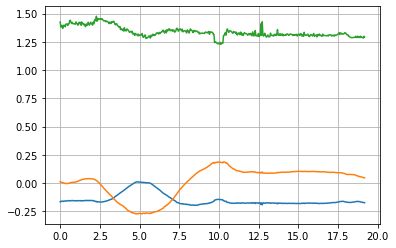

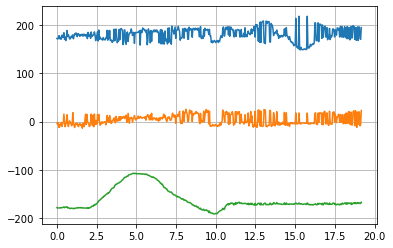

In [23]:
# imports
import cv2 # Import the OpenCV library to enable computer vision
import numpy as np # Import the NumPy scientific computing library
import math # Math library
import matplotlib.pyplot as plt

# Side length of the ArUco marker in meters 
aruco_marker_side_length = 0.04
 
# Calibration parameters yaml file
camera_calibration_parameters_filename = 'calibration_chessboard.yaml'

video_file = "MVI_7089.MOV"

# Recall the camera calibration parameters
cv_file = cv2.FileStorage(
camera_calibration_parameters_filename, cv2.FILE_STORAGE_READ) 
mtx = cv_file.getNode('K').mat()
dst = cv_file.getNode('D').mat()
cv_file.release()

# Get the used dictionary and create the detector object
this_aruco_dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)
this_aruco_parameters = cv2.aruco.DetectorParameters()
this_aruco_detector = cv2.aruco.ArucoDetector(this_aruco_dictionary, this_aruco_parameters)


# Open the video and get the number of frames
video = cv2.VideoCapture(video_file)
nframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_size = (frame_width, frame_height)

# Open the VideoWriter object
writer = cv2.VideoWriter(video_file[0:-4] + '_marked.avi', 
                           cv2.VideoWriter_fourcc(*'MJPG'),
                           25, frame_size)


# allocate a vector for each Euler angle
roll_vec = []
pitch_vec = []
yaw_vec = []
pos1_x = []
pos1_y = []
pos1_z = []

for n in range(nframes):
    print(f"Reading frame {n+1} of {nframes}") 
    
    # Read a frame
    ret, frame = video.read()
    
    # detect the markers
    (corners, marker_ids, rejected) = this_aruco_detector.detectMarkers(frame)
    
    pos1_x.append(np.NAN)
    pos1_y.append(np.NAN)
    pos1_z.append(np.NAN)
    roll_vec.append(np.NAN)
    pitch_vec.append(np.NAN)
    yaw_vec.append(np.NAN)
    
    if marker_ids is not None:
        
        # write detected marker onto the current frame
        # Draw a square around detected markers in the video frame
        cv2.aruco.drawDetectedMarkers(frame, corners, marker_ids)
        
        #object_points = np.zeros((4,3), dtype=np.float32)
        object_points = np.array([[-aruco_marker_side_length/2, aruco_marker_side_length/2, 0],
                            [aruco_marker_side_length/2, aruco_marker_side_length/2, 0],
                            [aruco_marker_side_length/2, -aruco_marker_side_length/2, 0],
                            [-aruco_marker_side_length/2, -aruco_marker_side_length/2, 0]],dtype=np.float32)

 
        for i, marker_id in enumerate(marker_ids):
        
            success, rvec, tvec = cv2.solvePnP(object_points, corners[i],mtx,dst, False, cv2.SOLVEPNP_IPPE_SQUARE)

            if success and marker_id==1:
                
                # write marker axes onto the current frame
                cv2.drawFrameAxes(frame, mtx, dst, rvec, tvec, 0.1)
                
                # convert rotation vector to rotation matrix, then to quaternion, and finally to Euler angles
                rotation_matrix, jacob = cv2.Rodrigues(rvec)

                pose_mat = cv2.hconcat((rotation_matrix, tvec))
                _, _, _, _, _, _, euler_angles = cv2.decomposeProjectionMatrix(pose_mat)

                pos1_x[n] = tvec[0][0]
                pos1_y[n] = tvec[1][0]
                pos1_z[n] = tvec[2][0]

                roll_vec[n] = euler_angles[0]
                pitch_vec[n] = euler_angles[1]
                yaw_vec[n] = euler_angles[2]


    # write the modified frame to the VideoWriter
    writer.write(frame)
    
# release video
video.release()

# release VideoWriter
writer.release()

# plot marker position
time = np.arange(0,nframes/25,1/25)
plt.figure()
plt.plot(time, pos1_x)
plt.plot(time, pos1_y)
plt.plot(time, pos1_z)
plt.grid()

# plot Euler angle graphs
time = np.arange(0,nframes/25,1/25)
plt.figure()
plt.plot(time, np.unwrap(roll_vec, axis=0,  period=360))
plt.plot(time, np.unwrap(pitch_vec, axis=0, period=360))
plt.plot(time, np.unwrap(yaw_vec, axis=0, period=360))
plt.grid()